In [23]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.naive_bayes import *
from sklearn.linear_model import LinearRegression

In [24]:
data = pd.read_csv("AirPassengers.csv", index_col=0).iloc[:,0]

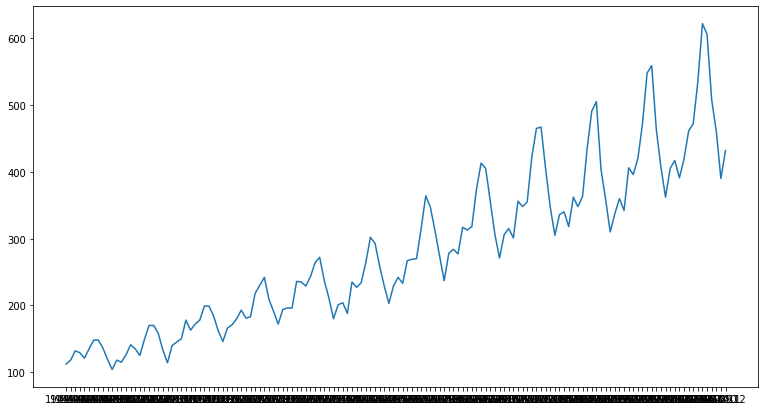

In [25]:
plt.figure(figsize=(13,7))
plt.plot(data)

In [26]:
test_period = 10
train= data.iloc[:-test_period]
test = data.iloc[-test_period:]

In [27]:
trend_removed = train.diff()

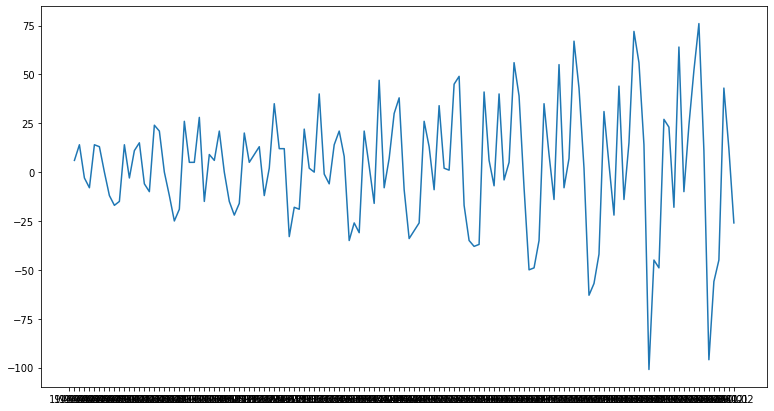

In [28]:
plt.figure(figsize=(13,7))
plt.plot(trend_removed)

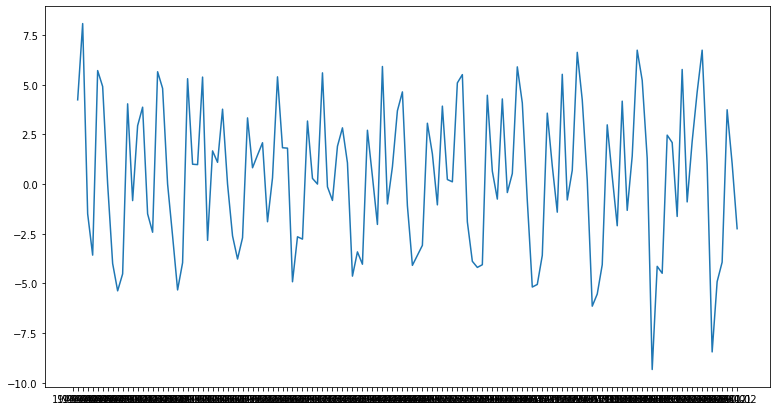

In [29]:
t_train = np.arange(len(train)).reshape(-1,1)
trend_removed = trend_removed / ((t_train+1)**(1/2)).reshape(-1)
plt.figure(figsize=(13,7))
plt.plot(trend_removed)

In [30]:
n_bins = 10
bins = np.linspace(trend_removed.min(), trend_removed.max(), n_bins)
binned = np.digitize(trend_removed, bins)

binned_series = pd.Series(binned, index = trend_removed.index)

In [31]:
bin_means = {}

for binn in range(1,n_bins+1):
    bin_means[binn] = trend_removed[binned == binn].mean()

In [32]:
lagged_list = []
for s in range(13):
    lagged_list.append(binned_series.shift(s))
    
lagged_frame = pd.concat(lagged_list,1).dropna()

train_X = lagged_frame.iloc[:,1:]
train_y = lagged_frame.iloc[:,0]

In [33]:
train_X.head()

,1,2,3,4,5,6,7,8,9,10,11,12
Month,,,,,,,,,,,,
1950-01,7.0,3.0,3.0,3.0,5.0,8.0,8.0,3.0,5.0,10.0,8.0,10.0
1950-02,5.0,7.0,3.0,3.0,3.0,5.0,8.0,8.0,3.0,5.0,10.0,8.0
1950-03,7.0,5.0,7.0,3.0,3.0,3.0,5.0,8.0,8.0,3.0,5.0,10.0
1950-04,7.0,7.0,5.0,7.0,3.0,3.0,3.0,5.0,8.0,8.0,3.0,5.0
1950-05,5.0,7.0,7.0,5.0,7.0,3.0,3.0,3.0,5.0,8.0,8.0,3.0


In [34]:
train_y.head()

Month
1950-01    5
1950-02    7
1950-03    7
1950-04    5
1950-05    4
Name: 0, dtype: int64

In [35]:
def get_mean_from_class(prediction):
    
    return(bin_means[prediction[0]])

In [36]:
model = GaussianNB()

In [37]:
model.fit(train_X,train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [38]:
pred_insample = model.predict(train_X)
pred_insample = pd.DataFrame(pred_insample, index=train_y.index)
resulting_prediction = pd.Series(np.nan , index = train_y.index)
for row in range(len(pred_insample)):
    resulting_prediction.iloc[row] = get_mean_from_class(pred_insample.values[row])

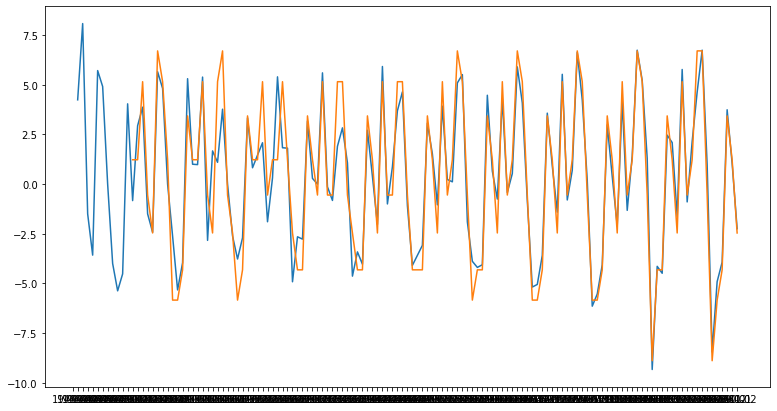

In [39]:
plt.figure(figsize = (13,7))
plt.plot(trend_removed)
plt.plot(resulting_prediction)

In [40]:
prediction_frame = pd.DataFrame(np.nan, index = test.index, columns = range(train_X.shape[1]))
predictions = pd.Series(index = test.index)

prediction_frame.iloc[0,1:] = train_X.iloc[-1,:-1].values
prediction_frame.iloc[0,0] = train_y.iloc[-1]

In [41]:
for i in range(len(test)):
    pred = model.predict(prediction_frame.iloc[i,:].values.reshape(1,-1))
    pred_num = get_mean_from_class(pred.reshape(-1))
    predictions.iloc[i] = pred_num
    try:
        prediction_frame.iloc[i+1,1:] = prediction_frame.iloc[i,:-1].values
        prediction_frame.iloc[i+1,0] = pred[0]
    except:
        pass

In [42]:
trend_test = np.arange(len(train),len(train)+len(test)).reshape(-1,1)

final_prediction = predictions.cumsum()* ((trend_test+1)**(1/2)).reshape(-1)+train.iloc[-1]

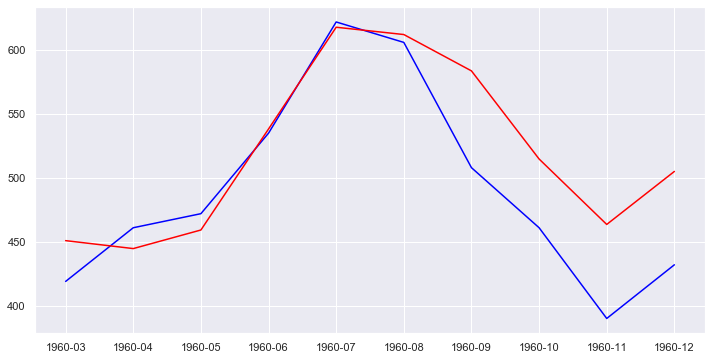

In [92]:
plt.figure(figsize = (12,6))
plt.plot(test,color='blue',label='test')
plt.plot(final_prediction, color = 'red', label='prediction')


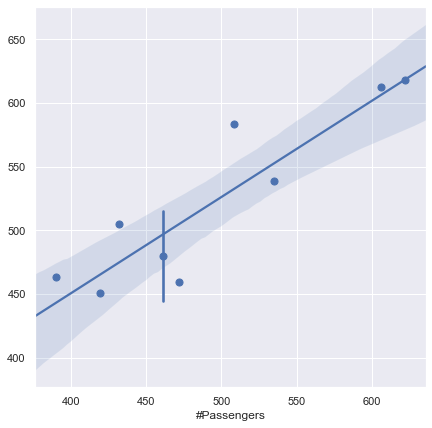

In [86]:
import seaborn as sns
sns.regplot(test,final_prediction, x_estimator=np.mean)
plt.show()


In [44]:
np.sqrt(np.mean((test-final_prediction)**2))

45.70389263808727

In [45]:
final_prediction

Month
1960-03    450.904300
1960-04    444.689662
1960-05    459.228985
1960-06    538.268190
1960-07    617.876413
1960-08    612.160993
1960-09    583.720598
1960-10    514.784355
1960-11    463.577966
1960-12    505.046027
dtype: float64

In [54]:
test

Month
1960-03    419
1960-04    461
1960-05    472
1960-06    535
1960-07    622
1960-08    606
1960-09    508
1960-10    461
1960-11    390
1960-12    432
Name: #Passengers, dtype: int64

In [46]:
fin=pd.DataFrame(test,final_prediction)

In [53]:
fin.to_csv('final.csv')